# PV Fault detection



<table>
  <tr>
    <td><img src="logos/CSTB_logo.jpg" width="200" />
    <td><img src="logos/Heliocity_logo.png" width="200" /> 
    <td><img src="logos/USMB_logo_horizontal.png" width="200" />
  </tr>
</table>

<sub>Author: Alexandre MATHIEU, Phd Student, in collaboration Heliocity / CSTB / USMB (LOCIE). </sub>
<sub>Phd thesis: Methodology development to guarantee building photovoltaic systems' performance including failure modelling</sub>


This notebook introduces some tools to automatically detect faults on PV installation which decreases power production.

It is broken down into three parts:

1. **Data visualization**: Exploration of weather and PV data
2. **Power model fit**: Estimation of DC power without faults in order to have a benchmark
3. **Fault detection**: Algorithm development to automatically detect power underperformances

The attendees are very much welcome to modify and create/execute some new notebook cells to explore data and try out new methods.

The two first parts are used to introduce the subject and the attendees are expected to collaborate and develop detection methods in the part 3. 

**Make sure to manually execute the cells (ctrl + enter) yourself one by one**

The notebook is highly supported from the pvlib toolbox: https://pvlib-python.readthedocs.io/en/stable/

In [1]:
# import packages
import os
import sys
import inspect

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.optimize import curve_fit
from pvlib.temperature import  pvsyst_cell
from pvlib.pvsystem import pvwatts_dc 

# Change the directory path to import functions from local modules
if not 'workbookDir' in globals():
    workbookDir = Path(os.getcwd()).parent
print('Work directory: ' + str(workbookDir))
os.chdir(workbookDir)

from src.config import ROOT # Directory ROOT path
from src.utils.helio_fmt import setup_helio_plt 
from src.utils.vizualization_tools import cldr_heatmap
setup_helio_plt() # set plot format and font

Work directory: C:\Users\MATHIEU\OneDrive - CSTBGroup\Bureau\Code\pvfault_detection


# I. Data visualization

## Satellite weather data

In [2]:
# Create index to force the data to be between 01/08 and 01/11 at 15min granularity
index = pd.date_range("20190801", "20191101", freq="15min", tz="CET")

# Load satellite weather data: incident irradiation, direct irradiation, temperature, wind
weather_data = pd.read_csv(ROOT / "data" / "meteo_sample.csv", index_col=0) 

weather_data["temp_air"] = weather_data["temp_air"] - 273.15  # Convert temperature to Celcius
weather_data.index = pd.to_datetime(weather_data.index)  # Convert the index to a datetime index
weather_data = weather_data.reindex(index)  # Make sure the index is correct

weather_data.dropna().head()  # Show the first lines

poa_global  poa_diffuse  ghi  ghi_c  temp_air  \
2019-08-01 02:00:00+02:00         0.0          0.0  0.0    0.0     17.24   
2019-08-01 02:15:00+02:00         0.0          0.0  0.0    0.0     17.09   
2019-08-01 02:30:00+02:00         0.0          0.0  0.0    0.0     16.93   
2019-08-01 02:45:00+02:00         0.0          0.0  0.0    0.0     16.79   
2019-08-01 03:00:00+02:00         0.0          0.0  0.0    0.0     16.67   

                           wind_speed  rain_fall  
2019-08-01 02:00:00+02:00        2.09        0.0  
2019-08-01 02:15:00+02:00        2.10        0.0  
2019-08-01 02:30:00+02:00        2.10        0.0  
2019-08-01 02:45:00+02:00        2.11        0.0  
2019-08-01 03:00:00+02:00        2.11        0.0

Following the naming convention from pvlib: https://pvlib-python.readthedocs.io/en/stable/user_guide/variables_style_rules.html#variables-style-rules

- **poa_global**: global irradiation in plane. sum of diffuse and beam projection [W/m2]
- **poa_diffuse**: total diffuse irradiation in plane. sum of ground and sky diffuse [W/m2]
- **ghi**: global horizontal irradiance [W/m2]
- **ghi_c**: Clear-sky global horizontal irradiance [W/m2]
- **temp_air**: temperature of the air, for this workshop [°C]
- **wind_speed**: wind speed [m/s]
- **rain_fall**: rain fall [mm]

<IPython.core.display.Javascript object>


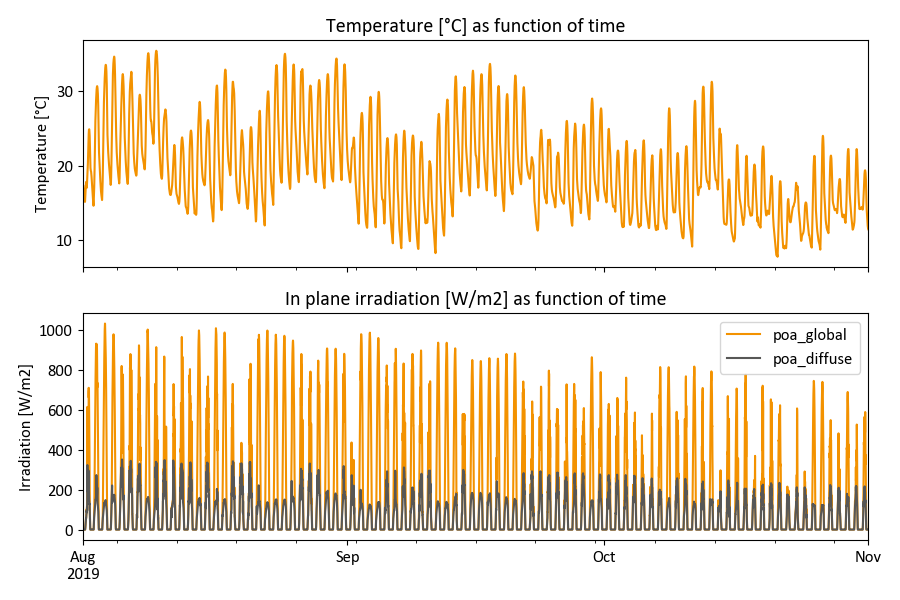

In [8]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,6), sharex=True)
weather_data["temp_air"].plot(ax=ax1, title="Temperature [°C] as function of time",ylabel="Temperature [°C]")
meteo_plot = weather_data[["poa_global","poa_diffuse"]]
meteo_plot.plot(ax=ax2, title="In plane irradiation [W/m2] as function of time",ylabel="Irradiation [W/m2]")
plt.tight_layout()

## PV electric data

The installation is comprised of module strings in parallel.

Each string is comprised of 21 modules.

In [4]:
# Load  pv data
pv_data = pd.read_csv(ROOT / "data" / "pv_data_sample.csv", index_col=0) # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data["Pdc"] = pv_data["Vdc"] * pv_data["Idc"] # Calculates DC power Pdc
pv_data.index = pd.to_datetime(pv_data.index) # Convert the index to a datetime index
pv_data = pv_data.reindex(index) # Make sure the index is correct

pv_data.dropna().head()  # Show the first lines

Vdc   Idc    Pac          Pdc
2019-08-01 06:45:00+02:00  519.0  0.07    0.0    36.330000
2019-08-01 07:00:00+02:00  580.0  0.04    1.0    23.199999
2019-08-01 07:15:00+02:00  583.0  0.32   15.0   186.559996
2019-08-01 07:30:00+02:00  485.0  1.48  244.0   717.800009
2019-08-01 07:45:00+02:00  555.0  2.31  734.0  1282.049968

<IPython.core.display.Javascript object>


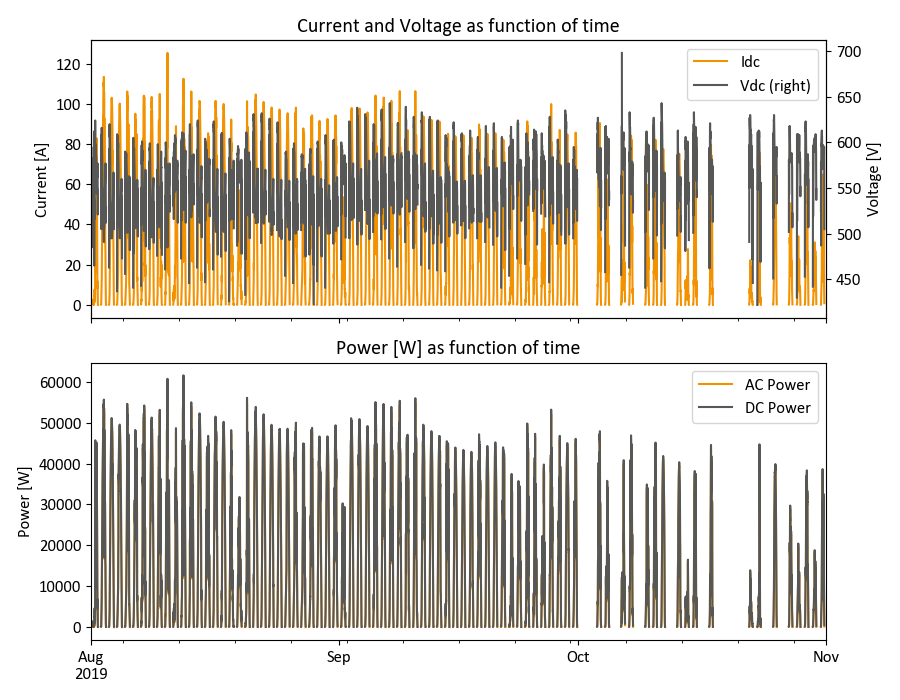

In [5]:
%matplotlib notebook

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data["Idc"].plot(ax=ax1, title="Current and Voltage as function of time", ylabel="Current [A]", legend=True)
pv_data["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time", ylabel="Power [W]")
plt.tight_layout()

Another way of vizualizing quickly PV data is to plot the power heatmap with the color representing the level of power production as function of time (x-axis) and date (y-axis)

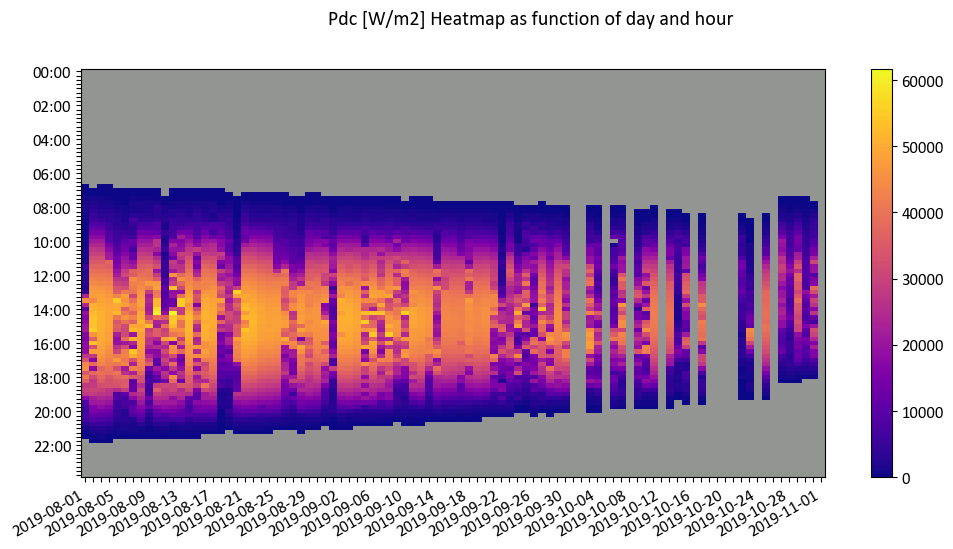

In [6]:
%matplotlib inline
_ = cldr_heatmap(pv_data, "Pdc", figure_title="Pdc [W/m2] Heatmap as function of day and hour", colormap="plasma")

First things to notice are:
    
- Some periods with missing data in october
- The Daylight Saving Time (DST) shift at the end of october

# II. Power model fit

Modeling PV power goes into two steps:

1. Modeling the module cell temperature. 
2. Modeling the installation power (which requires the cell temperature as input)

Modeling acurately the cell temperature is crucial since the power generation is highly sensible to it.

## A. Cell temperature model

The cell temperature is modeled according to PvSyst model provided from pvlib.

$$ T_{C} = T_{a} + \frac{\alpha E (1 - \eta_{m})}{U_{c} + U_{v} \times WS} $$

with $T_{C}$ the cell temperature, $T_{a}$ the air temperature,  $E$ the total incident irradiance, $WS$ the wind speed


https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.temperature.pvsyst_cell.html

<IPython.core.display.Javascript object>


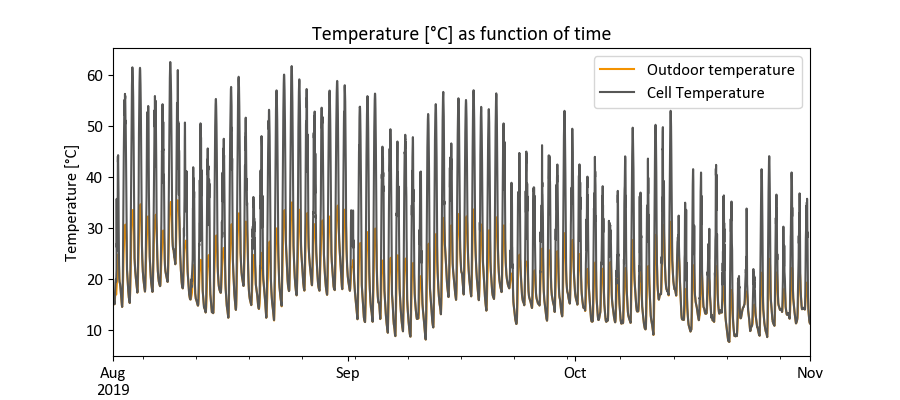

<AxesSubplot: title={'center': 'Temperature [°C] as function of time'}, ylabel='Temperature [°C]'>

In [7]:
%matplotlib notebook
# Approximates cell temperature thanks to pvsyst model (provided from pvlib) 
u_c = 29  # Assumption: freestanding
u_v = 0  # No subject to wind cooling effect
temp_cell = pvsyst_cell(weather_data["poa_global"], weather_data["temp_air"], weather_data["wind_speed"], u_c=u_c, u_v=u_v)
    
fig, ax = plt.subplots(1, 1, figsize=(9,4), sharex=True)
weather_data["temp_air"].to_frame("Outdoor temperature").plot(ax=ax, title="Temperature [°C] as function of time",ylabel="Temperature [°C]")
temp_cell.to_frame("Cell Temperature").plot(ax=ax)

## B. Pdc power model

### PvWatt model fit

The DC power production is modelled according to PvWatt model, provided from pvlib.

$$P_{dc} = \frac{G_{poa eff}}{1000} P_{dc0} ( 1 + \gamma_{pdc} (T_{cell} - T_{ref}))$$

with $P_{dc}$ the DC power, $G_{poa eff}$ the irradiance transmitted to the PV cells,  $T_{cell}$ the cell temperature

Two parameters:   $P_{dc0}$, $\gamma_{pdc}$ respectively the nameplate DC rating and the temperature coefficient

References:
    
    
- Sandia: https://pvpmc.sandia.gov/modeling-steps/2-dc-module-iv/point-value-models/pvwatts/
- Pvlib: https://pvlib-python.readthedocs.io/en/v0.4.2/generated/pvlib.pvsystem.pvwatts_dc.html

In [9]:
# Fit with brute force pvwatt power model (provided from pvlib) 
def func_to_fit(X, pdc0, gamma_pdc):
    g_poa_effective, temp_cell = X    
    pdc = pvwatts_dc(g_poa_effective, temp_cell, pdc0, gamma_pdc, temp_ref=25.0)
    return pdc 

# Filter all inputs on august 2019 (most stable period of the dataset without missing values) 
# and when poa_global > 400 W/m2 (where the model usually performs the best) to fit the model
august_index = weather_data[weather_data["poa_global"]>400].index
august_index = august_index[(august_index > '2019-08-01 00:00:00+02:00') & (august_index < '2019-09-01 00:00:00+02:00')]
index_fit = pv_data.loc[august_index, "Pdc"].dropna().index
pdc_fit = pv_data["Pdc"].reindex(index_fit)
g_poa_effective_fit = weather_data["poa_global"].reindex(index_fit)  # Roughly assume g_poa_effective is equal to poa_global
temp_cell_fit = temp_cell.reindex(index_fit)

# Fit with initial guesses for pvwatt model parameters: P0 and gamma
p0 = (40000., -0.002)
pdc0, gamma_pdc = curve_fit(func_to_fit, (g_poa_effective_fit, temp_cell_fit), pdc_fit, p0)[0]

# Estimating Pdc from satellite data (irradiation and cell temperature coming from ambient temperature & irradiation)
pdc_estimated = pvwatts_dc(weather_data["poa_global"], temp_cell, pdc0, gamma_pdc, temp_ref=25.0)

### PvWatt model accuracy exploration

In [10]:
error = (pdc_estimated - pv_data["Pdc"])
error_mean= error.abs().sum() / pv_data["Pdc"].abs().sum()
print(f"The average error of the model is {round(error_mean * 100, 2)}%")

The average error of the model is 14.78%


<IPython.core.display.Javascript object>


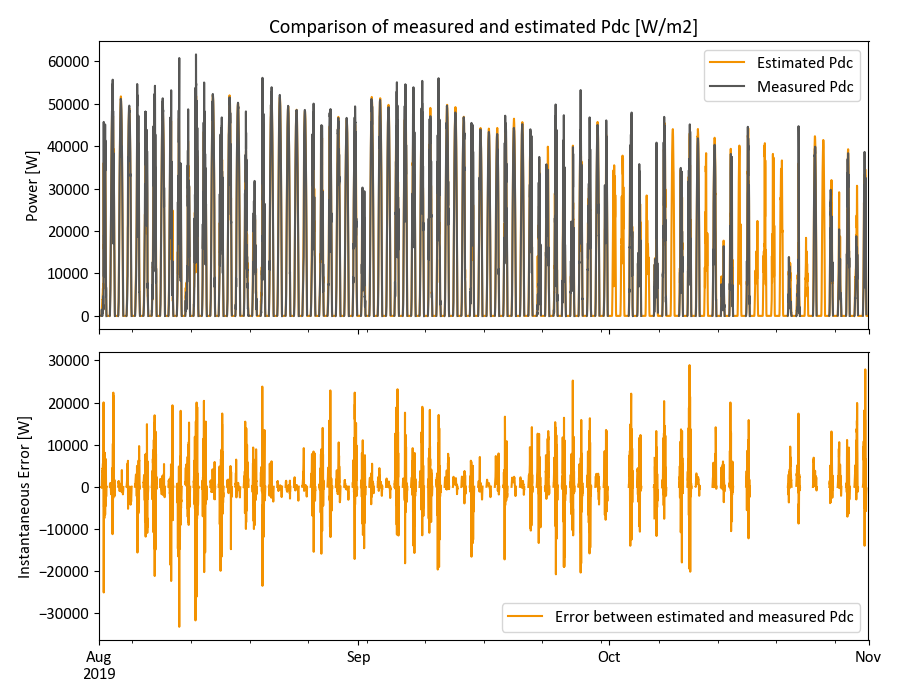

In [11]:
%matplotlib notebook


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pdc_estimated.to_frame("Estimated Pdc").plot(ax=ax1, title="Comparison of measured and estimated Pdc [W/m2]", ylabel="Power [W]")
pv_data["Pdc"].to_frame("Measured Pdc").plot(ax=ax1)
error.to_frame("Error between estimated and measured Pdc").plot(ax=ax2,  ylabel="Instantaneous Error [W]")

plt.tight_layout()

Satellite data, on which the power model is based, have trouble to reflect real-local conditions on cloudy days and is therefore less accurate during those periods.

The plot below illustrates it.

The more cloudy it is (the lower the clear sky index is), the less accurate the model is


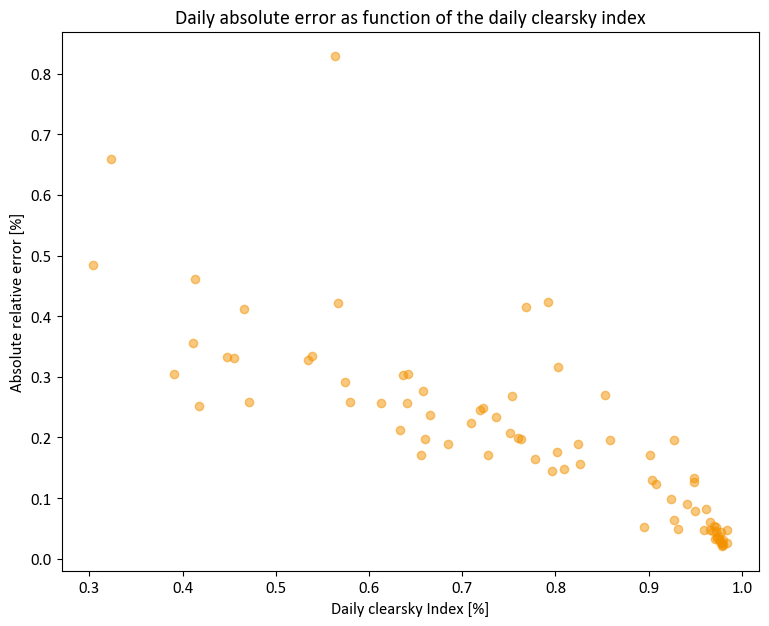

In [12]:
%matplotlib inline
# The clear sky index is calculated from satellite data as the ratio between the estimated irradiation and the theoretical
# received irradiation if there is no clouds
clearsky_daily = weather_data["ghi"].resample("D").sum() / weather_data["ghi_c"].resample("D").sum()

# Calculate the daily error
error_daily = (error.abs().resample("D").sum() / pv_data["Pdc"].resample("D").sum())

fig, ax = plt.subplots(1, 1, figsize=(9,7), sharex=True)
plt.plot(clearsky_daily, error_daily, linewidth=0, marker="o", alpha=0.5)
plt.title("Daily absolute error as function of the daily clearsky index")
plt.ylabel("Absolute relative error [%]")
plt.xlabel("Daily clearsky Index [%]")
print("The more cloudy it is (the lower the clear sky index is), the less accurate the model is")

Thanks to the estimate, the missing production data can be quantified

In [13]:
missing_loss_perc = pdc_estimated.loc[pv_data["Pdc"].isna()].sum() / pdc_estimated.sum()
print(f"Missing data represents {round(missing_loss_perc*100, 2)}% of the total production")

Missing data represents 9.1% of the total production


# III. Fault detection

In this section attendees would participate:

1. Develop methods to detect periods with underperformances
2. Quantify those underperformances in % compared to the estimate

## A. Shading

A fixed-rectangular shading (like a building) obstructs the irradiation to the PV installation.

**Goal**: Identify when shading occurs, flag those periods and quantify the losses.

One solution could include the latitude and longitude as input: roughly (48,3)

<IPython.core.display.Javascript object>


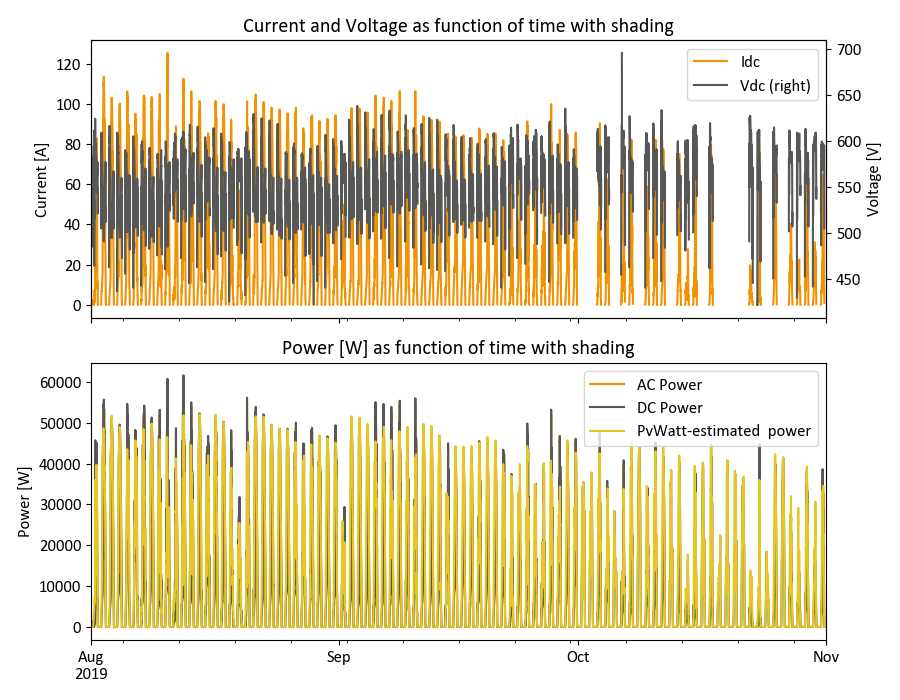

In [14]:
# Import pv data including shading 
pv_data_shading = pd.read_csv(ROOT / "data" / "pv_data_shading.csv", index_col=0)  # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data_shading.index = pd.to_datetime(pv_data_shading.index) # Convert the index to a datetime index
pv_data_shading = pv_data_shading.reindex(index) # Make sure the index is correct

# Fill missing values with estimated Pdc from PvWatt model
pv_data_shading.loc[pv_data_shading["Pdc"].isna(), "Pdc"] = pdc_estimated.loc[pv_data_shading["Pdc"].isna()]

%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_shading["Idc"].plot(ax=ax1, title="Current and Voltage as function of time with shading", ylabel="Current [A]", legend=True)
pv_data_shading["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data_shading[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time with shading", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power").plot(ax=ax2)
plt.tight_layout()

#### Solution 1

A preliminary solution can be to evaluate for each point against thresholds:
    
- The punctual relative error
- The recurrent relative error comprised within a time-window
- The punctual relative error against the reduction of irradiation in case the shading element blocks the beam irradiation component

In [15]:
from src.fault_detection import shading_detection
source_shading = inspect.getsource(shading_detection)
print(source_shading)

def shading_detection(pdc: pd.Series,
                      pdc_estimated: pd.Series,
                      poa_global: pd.Series,
                      poa_diffuse: pd.Series,
                      error_rel_thresh: float = 0,
                      error_window_thresh: float = 0.5,
                      gib_gid_ratio_thresh: float = 0.5,
                      window: str = "31D") -> pd.Series:
    """
    Flag shading based on DC power and diffuse/global irradiation.

    The algorithm assesses  punctual, recurrent relative errors as well as the punctual relative error vs the relative
    reduction of irradiation if the beam irradiation component is blocked due to shading.
    Those three elements are compared against thresholds and if the three conditions are met, it flags the datetime as
    shading.

    Note that the algorithm has troubles after the Daylight Saving Time and still needs improvement during
    shading-transition periods over the day.

    :param pdc: DC power [W/m2]

In [16]:
shading_flags = shading_detection(pv_data_shading["Pdc"], pdc_estimated, weather_data["poa_global"], weather_data["poa_diffuse"], 
                                  error_rel_thresh=0.1, error_window_thresh=0.5,  gib_gid_ratio_thresh=0.5)

<IPython.core.display.Javascript object>


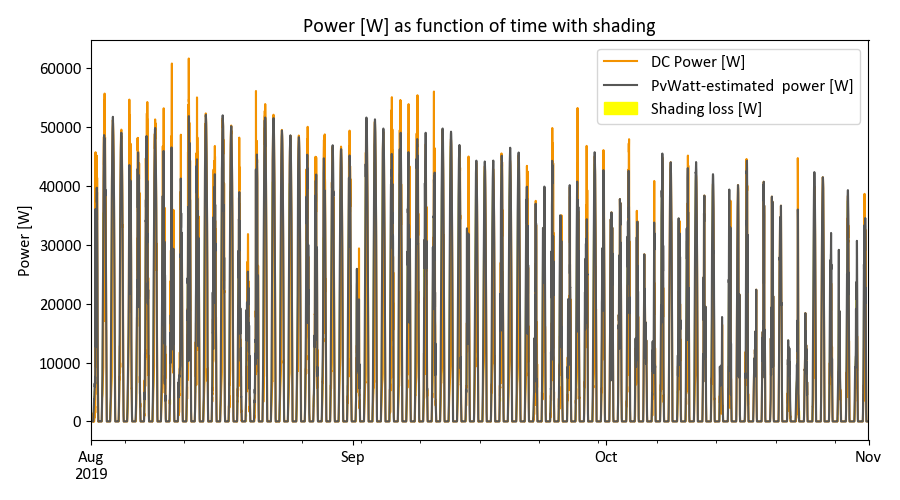

In [17]:
# Dataframe built for plotting purpose
shading_loss = pd.DataFrame(index=pv_data_shading.index, columns=["Pdc","Pdc_estimated","loss","shading"], data=0)
shading_loss["shading"] = False
shading_loss.loc[shading_flags, "shading"] = shading_flags
shading_loss.loc[:,"Pdc"] = pv_data_shading.loc[shading_flags, "Pdc"]
shading_loss.loc[:,"Pdc_estimated"] = pdc_estimated[shading_flags]
shading_loss["loss"] = shading_loss["Pdc_estimated"]  - shading_loss["Pdc"] 

%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(9,5))
pv_data_shading["Pdc"].to_frame("DC Power [W]").plot(ax=ax, title="Power [W] as function of time with shading", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power [W]").plot(ax=ax)
plt.fill_between(shading_loss.index, shading_loss["Pdc"], shading_loss["Pdc_estimated"], color="yellow", label="Shading loss [W]")
plt.legend()
plt.tight_layout()

In [18]:
shading_loss_perc = shading_loss["loss"].sum() / pdc_estimated.sum()
print(f"Shading induces {round(shading_loss_perc*100, 2)}% of losses out of the total production")

Shading induces 17.56% of losses out of the total production


#### Solution 2

This solution is machine-learning based and relies on KNN clustering from the following features:
    
- Sun azimuth
- Sun elevation 
- Sun relative error 

In [19]:
from src.fault_detection import error_cluster
source_cluster = inspect.getsource(shading_detection)
print(source_cluster)

def shading_detection(pdc: pd.Series,
                      pdc_estimated: pd.Series,
                      poa_global: pd.Series,
                      poa_diffuse: pd.Series,
                      error_rel_thresh: float = 0,
                      error_window_thresh: float = 0.5,
                      gib_gid_ratio_thresh: float = 0.5,
                      window: str = "31D") -> pd.Series:
    """
    Flag shading based on DC power and diffuse/global irradiation.

    The algorithm assesses  punctual, recurrent relative errors as well as the punctual relative error vs the relative
    reduction of irradiation if the beam irradiation component is blocked due to shading.
    Those three elements are compared against thresholds and if the three conditions are met, it flags the datetime as
    shading.

    Note that the algorithm has troubles after the Daylight Saving Time and still needs improvement during
    shading-transition periods over the day.

    :param pdc: DC power [W/m2]

Text(0.5, 1.0, 'KNN-error class as function of azimuth and elevation')

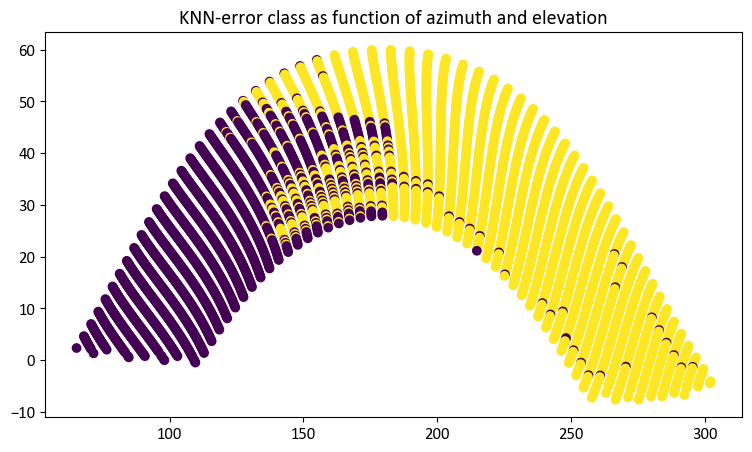

In [20]:
from pvlib.solarposition import get_solarposition

# Extract the azimuth and elevation of the sun paths
latitude, longitude = 48,3
solar_pos = get_solarposition(index, latitude, longitude)
azimuth = solar_pos["azimuth"]
elevation = solar_pos["elevation"] 

features = pd.concat([azimuth.to_frame("azimuth"), elevation.to_frame("elevation")], axis=1).dropna()
error = error_cluster(pv_data_shading["Pdc"], pdc_estimated, features)

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(9,5))
plt.scatter(error["azimuth"], error["elevation"], c=error["class"])
plt.title("KNN-error class as function of azimuth and elevation")

The outputs of this solution could be used to infer the azimuth/elevation of the shading element in order to complement the solution 1.

## B. Inverter clipping

Inverter clipping refers to the maximum production AC limit of the inverter. In that case, the power production caps at a certain limit even if the PV field could produce more.

**Goal**: Identify the AC threshold, flag the periods with inverter clipping and quantify the losses.

Note: The shading fault has been removed from the data and only the clipping has some effects

<IPython.core.display.Javascript object>


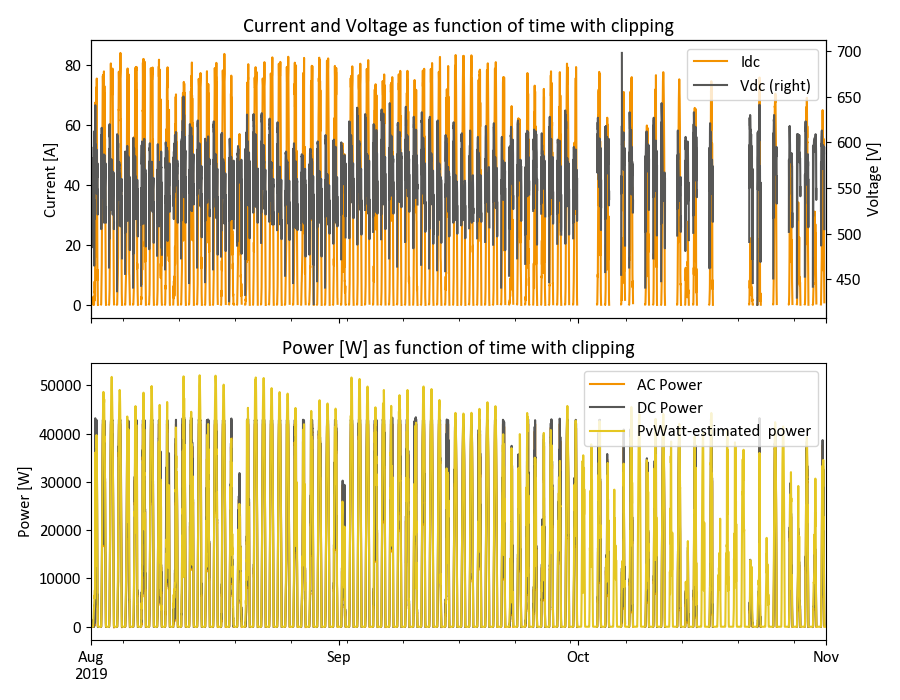

In [21]:
pv_data_clipping = pd.read_csv(ROOT / "data" / "pv_data_clipping.csv", index_col=0)  # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data_clipping.index = pd.to_datetime(pv_data_clipping.index) # Convert the index to a datetime index
pv_data_clipping = pv_data_clipping.reindex(index) # Make sure the index is correct


%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_clipping["Idc"].plot(ax=ax1, title="Current and Voltage as function of time with clipping", ylabel="Current [A]", legend=True)
pv_data_clipping["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data_clipping[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time with clipping", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power").plot(ax=ax2)
plt.tight_layout()

#### Solution

Luckily, a function is already built in pvanalytics to flag out the clipping datetimes.

https://pvanalytics.readthedocs.io/en/stable/generated/pvanalytics.features.clipping.threshold.html?highlight=threshold#pvanalytics.features.clipping.threshold

The technic relies on evaluating the threshold from the 99.5 % daily curve. Ie, for each time of day that 99.5% of the highest values are observed. The "plateau" (ceiling) value is then extracted.

<AxesSubplot: title={'center': '99.5 % time-quantile power curve'}, xlabel='time'>

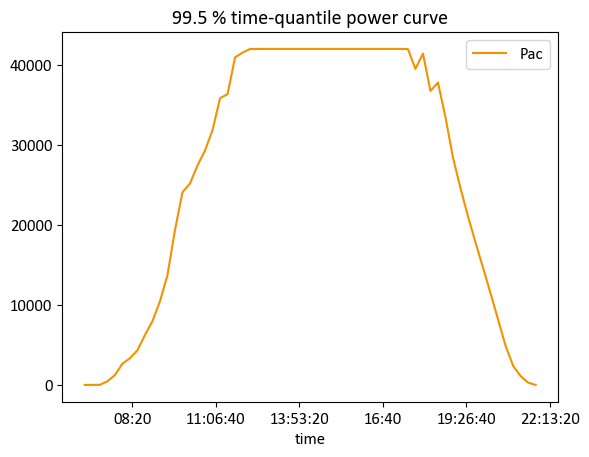

In [22]:
# 99.5% daily curve quantile
%matplotlib inline
pv_data_clipping["time"] = pv_data_clipping.index.time
pv_data_clipping[["Pac","time"]].groupby("time").quantile(0.995).plot(title="99.5 % time-quantile power curve")

In [23]:
from pvanalytics.features.clipping import threshold
clipping_flags = threshold(pv_data_clipping["Pac"])
clipping_flags = clipping_flags & (pdc_estimated > pv_data_clipping["Pdc"])

<IPython.core.display.Javascript object>


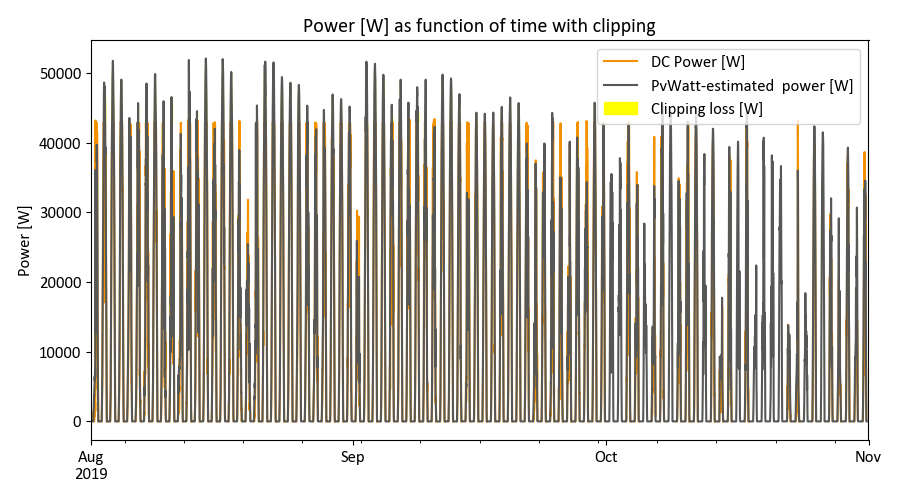

In [24]:
# Dataframe built for plotting purpose
def clipping_loss_calc(pv_data_clipping, pdc_estimated, clipping_flags):
    clipping_loss = pd.DataFrame(index=pv_data_clipping.index, columns=["Pdc","Pdc_estimated","loss","clipping"], data=0)
    clipping_loss["clipping"] = False
    clipping_loss.loc[clipping_flags, "clipping"] = clipping_flags
    clipping_loss.loc[:,"Pdc"] = pv_data_clipping.loc[clipping_flags, "Pdc"]
    clipping_loss.loc[:,"Pdc_estimated"] = pdc_estimated[clipping_flags]
    clipping_loss["loss"] = clipping_loss["Pdc_estimated"]  - clipping_loss["Pdc"] 
    return clipping_loss

clipping_loss = clipping_loss_calc(pv_data_clipping, pdc_estimated, clipping_flags)

%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(9,5))
pv_data_clipping["Pdc"].to_frame("DC Power [W]").plot(ax=ax, title="Power [W] as function of time with clipping", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power [W]").plot(ax=ax)
plt.fill_between(clipping_loss.index, clipping_loss["Pdc"], clipping_loss["Pdc_estimated"], color="yellow", label="Clipping loss [W]")
plt.legend()
plt.tight_layout()

In [25]:
clipping_loss_perc = clipping_loss["loss"].sum() / pdc_estimated.sum()
print(f"Clipping induces {round(clipping_loss_perc*100, 2)}% of losses")

Clipping induces 1.85% of losses


## C. Module short circuit

For the module short-circuit, it can be considered that the meter point is at the PV string level and the string is comprised of 21 modules.

One module in a string gets all its bypass diodes short-circuited.

**Goal**: Identify the date at which the short-circuit occurs and quantify the losses.

Note: The shading and inverter clipping effect have been removed.

<IPython.core.display.Javascript object>


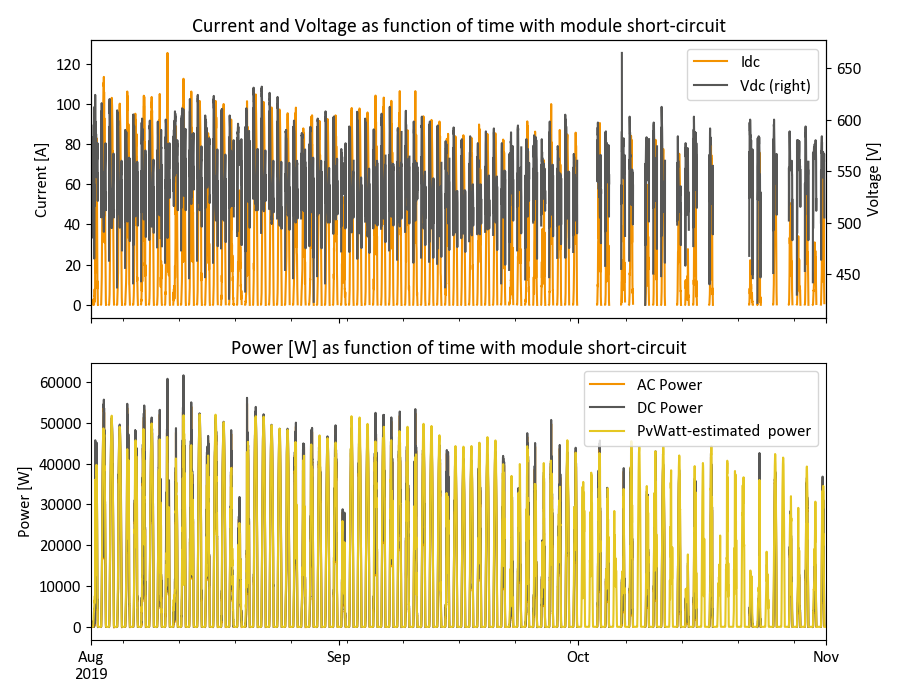

In [26]:
pv_data_shortcircuit = pd.read_csv(ROOT / "data" / "pv_data_shortcircuit.csv", index_col=0)  # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data_shortcircuit.index = pd.to_datetime(pv_data_shortcircuit.index) # Convert the index to a datetime index
pv_data_shortcircuit = pv_data_shortcircuit.reindex(index)  # Make sure the index is correct


%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_shortcircuit["Idc"].plot(ax=ax1, title="Current and Voltage as function of time with module short-circuit", ylabel="Current [A]", legend=True)
pv_data_shortcircuit["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data_shortcircuit[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time with module short-circuit", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power").plot(ax=ax2)
plt.tight_layout()

#### Hint

The total voltage of the field will be decreased by the module voltage and vmp can be deducted from King's model.

King, D. et al, 2004, "Sandia Photovoltaic Array Performance Model", SAND Report 3535, Sandia National Laboratories, Albuquerque,NM.

In [27]:
from src.pv_models import fit_vmp_king, vmp_king
source_vmp_king = inspect.getsource(vmp_king)
source_fit_vmp_king = inspect.getsource(fit_vmp_king)
print(source_vmp_king)
print(source_fit_vmp_king)

def vmp_king(goa_effective: pd.Series,
             temp_cell: pd.Series,
             c2: float,
             c3: float,
             beta: float,
             vmp_ref: float,
             reference_temperature: float = 25,
             reference_irradiance: float = 1000):
    """
    Estimate Vmp at the maximum power point according to King's model.

    The equation is slightly tweaked from the publication to remove the dependency on :math:`V_0`:

    .. math::

        V_{mpp} = Vmp_{ref} +  c2 * T_{cell_K} * log(Ee) +  c3 * (T_{cell_K} * log(Ee))^2 +
        beta * Ee * (T_{cell} - T_{ref})

    where :math:`Ee` is the effective irradiance and :math:`T_{cell}`, :math:`T_{cell_K}` the cell temperature in Celsius and Kelvin respectively.

    :param goa_effective: Irradiance reaching the module's cells, after reflections and  adjustment for spectrum. [W/m2]
    :param temp_cell:  Cell temperature [C].
    :param c2: Empirically determined coefficient
    :param c3: Empirically deter

In [28]:
(c2, c3, beta, vmp_ref) = fit_vmp_king(weather_data["poa_global"], temp_cell, vmp=pv_data["Vdc"])
vdc_estimated = vmp_king(weather_data["poa_global"], temp_cell, c2, c3, beta, vmp_ref)

<IPython.core.display.Javascript object>


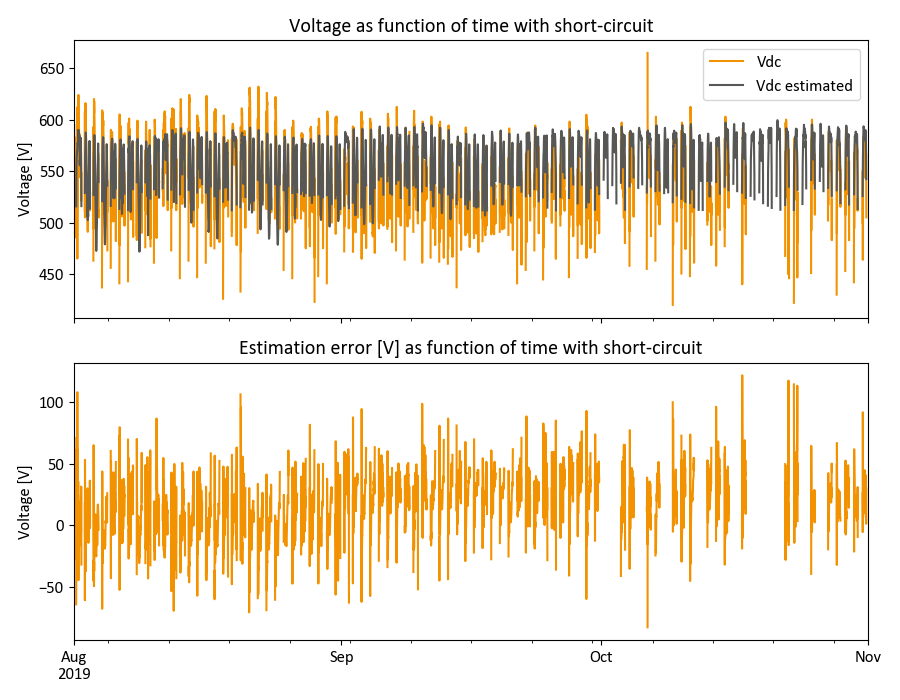

In [29]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_shortcircuit["Vdc"].plot(ax=ax1, title="Voltage as function of time with short-circuit", ylabel="Voltage [V]", legend=True)
vdc_estimated.to_frame("Vdc estimated").plot(ax=ax1, legend=True)
error_vdc = vdc_estimated - pv_data_shortcircuit["Vdc"]
error_vdc.plot(ax=ax2, title="Estimation error [V] as function of time with short-circuit",ylabel="Voltage [V]")
plt.tight_layout()

#### Solution

The PV voltage decreases roughly by 1/21 from 1st of September. 

Tracking the difference of the daily-mean averages between the estimate and measured Vdc allow to detect when the short-circuit occured.

In [30]:
from src.fault_detection import short_circuit_detection
source_sc = inspect.getsource(short_circuit_detection)
print(source_sc)

def short_circuit_detection(vdc: pd.Series,
                            vdc_estimated: pd.Series,
                            threshold: float = 20,
                            window: str = "15D"):
    """
    Flag the dates which induce a change in the error pattern between vdc and vdc_estimated.

    First, the daily error mean is calculated.
    Then, for each date, the error KPI is equal to the difference of the daily error means over a time-window before and
    after the date.

    :param vdc: DC Voltage [V] (including a short circuit)
    :param vdc_estimated: Estimated DC voltage [V]  (without short-circuit)
    :param threshold: All timestamps for which the indicator goes over the threshold are flagged as short_circuit
    :param window: number of days taken to average the daily error before and after each date

    :return: Flag when the Vdc-error KPI is over the threshold + the indicator itself in a pd.Series
    """
    daily_error = (vdc_estimated - vdc).resample("D").mea

In [31]:
threshold = pv_data["Vdc"].mean() * (1 / 21) * 70 / 100 # Multiply by 70% to allow some margin
flags_sc, error_kpi = short_circuit_detection(pv_data_shortcircuit["Vdc"], vdc_estimated, threshold)

sc_date = flags_sc[flags_sc].idxmin()
sc_date_dt = pd.to_datetime(sc_date).tz_localize("CET")
flags_sc[flags_sc]

2019-08-31    True
2019-09-01    True
dtype: bool

<IPython.core.display.Javascript object>


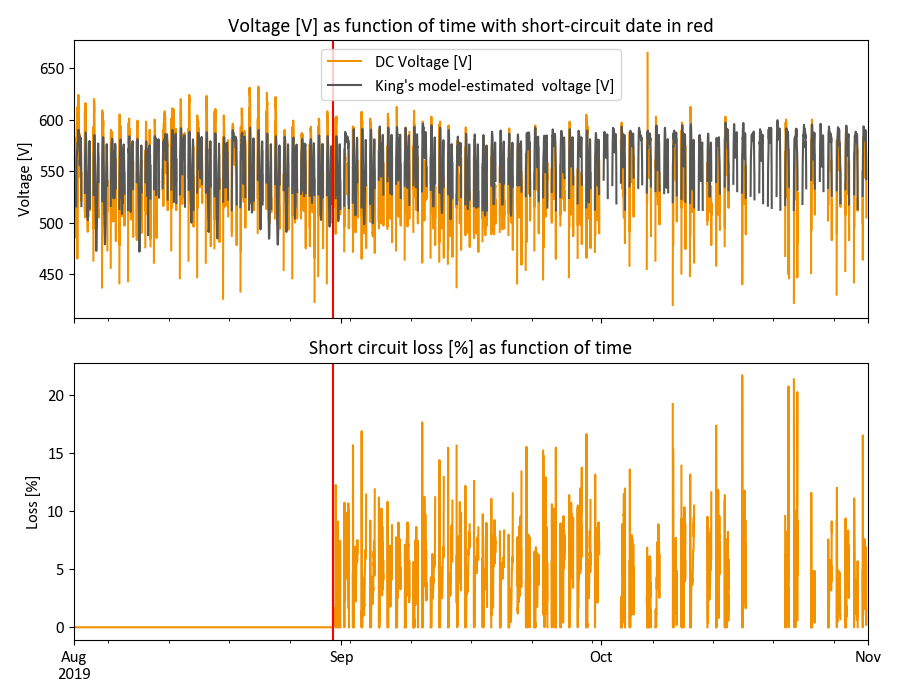

In [32]:
# Loss dataframe
shortcircuit_loss = pd.DataFrame(index=pv_data_clipping.index, columns=["loss_perc","shortcircuit"],data=0)
shortcircuit_loss["shortcircuit"] = False
shortcircuit_loss.loc[shortcircuit_loss.index > sc_date_dt, "shortcircuit"] = True
shortcircuit_loss["loss_perc"] = ((vdc_estimated - pv_data_shortcircuit["Vdc"]) / vdc_estimated * 100).clip(lower=0)
shortcircuit_loss.loc[~shortcircuit_loss["shortcircuit"], "loss_perc"] = 0

%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)

pv_data_shortcircuit["Vdc"].to_frame("DC Voltage [V]").plot(ax=ax1, title="Voltage [V] as function of time with short-circuit date in red", ylabel="Voltage [V]")
vdc_estimated.to_frame("King's model-estimated  voltage [V]").plot(ax=ax1, ylabel="Voltage [V]")
ax1.axvline(x=sc_date_dt, color="r")
shortcircuit_loss["loss_perc"].plot(ax=ax2, title="Short circuit loss [%] as function of time", ylabel="Loss [%]")
ax2.axvline(x=sc_date_dt, color="r")
plt.tight_layout()

In [33]:
shortcircuit_loss_perc = (shortcircuit_loss["loss_perc"] * pdc_estimated).sum()/ pdc_estimated.sum()
print(f"Short circuit induces {round(shortcircuit_loss_perc, 2)}% of losses")

Short circuit induces 2.31% of losses


## Bonus: Accounting all losses

Accounting and distinguish underperformances are not trivial since some of them could be double counted from the algorithms.

<IPython.core.display.Javascript object>


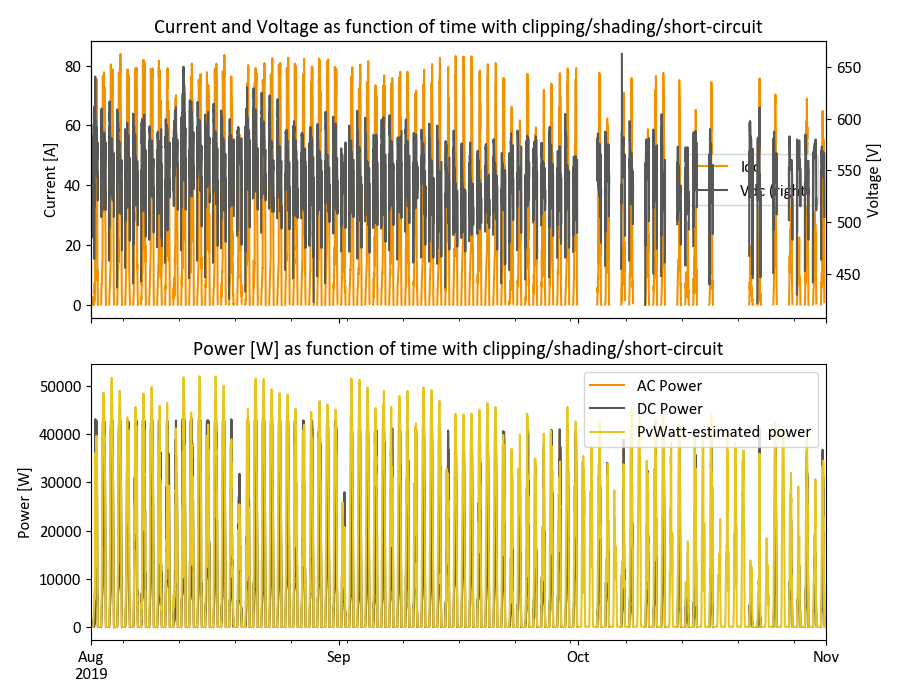

In [34]:
pv_data_all = pd.read_csv(ROOT / "data" / "pv_data_all_defaults.csv", index_col=0)  # DC Voltage "Vdc", DC Current "Idc", AC Power "Pac"
pv_data_all.index = pd.to_datetime(pv_data_all.index)  # Convert the index to a datetime index
pv_data_all = pv_data_all.reindex(index) # Make sure the index is correct

%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9,7), sharex=True)
pv_data_all["Idc"].plot(ax=ax1, title="Current and Voltage as function of time with clipping/shading/short-circuit", ylabel="Current [A]", legend=True)
pv_data_all["Vdc"].clip(lower=400).plot(ax=ax1, secondary_y=True, legend=True)
ax1.right_ax.set_ylabel('Voltage [V]')
pv_plot = pv_data_all[["Pac","Pdc"]].rename(columns={"Pac":"AC Power", "Pdc":"DC Power"})
pv_plot.plot(ax=ax2, title="Power [W] as function of time with clipping/shading/short-circuit", ylabel="Power [W]")
pdc_estimated.to_frame("PvWatt-estimated  power").plot(ax=ax2)
plt.tight_layout()

Identifying and quantifying losses are at the core of Heliocity algorithms. (https://www.heliocity.io/?lang=en). Especially, its new product allows to automatically estimate losses for any PV installation given its configuration inputs.

In [35]:
# Dummy dataframe
df = pd.DataFrame()
df.loc[1, "Base"] = 100
df.loc[2, "Natural ageing losses"] = -5#%
df.loc[3, "Missing data"] = -5#%
df.loc[4, "Soiling losses"] = -5#%
df.loc[5, "Inverter clipping losses"] = -2 #%
df.loc[6, "Shading losses"] = -10
df["index"] = df.loc[:,:].sum(axis=1).cumsum().shift(1)
df.fillna(0, inplace=True)

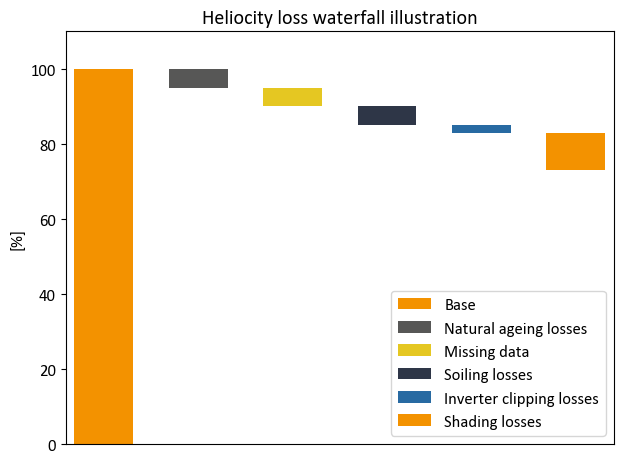

In [36]:
%matplotlib inline
columns= ["Base", "Natural ageing losses", "Missing data", "Soiling losses", "Inverter clipping losses", "Shading losses"]

df.loc[:,columns].plot(kind = "bar",  bottom = df["index"], width = 10)
plt.title("Heliocity loss waterfall illustration")
plt.xticks([])
plt.ylabel("[%]")
plt.ylim([0, 110])
plt.tight_layout()